# Predict House Price
### xgBoost Search Grid
Original full House Price prediction: 
https://github.com/ScottySchmidt/Kaggle/blob/main/PredictHousePrices.ipynb

##### Special Notes:
* Removing feature importance with less than .003% makes tunning more consisent with high results
* Tunning learning_rate improved 8% better score
* Removing outliers improved 4% better score
* Removing similiar features makes couple percent better score
* Encoding condition1 improved score by less than 1%

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
warnings.warn('my warning')

data='/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
df=pd.read_csv(data)
print(df.shape)
df.head()

(1460, 81)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: my warning
  


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Missing Values

In [2]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(data)
    print(findNA.head(10))
findNA() 

Missing data by column as a percent:
PoolQC          21.686567
MiscFeature     20.985075
Alley           20.432836
Fence           17.597015
FireplaceQu     10.298507
LotFrontage      3.865672
GarageYrBlt      1.208955
GarageCond       1.208955
GarageType       1.208955
GarageFinish     1.208955
dtype: float64


In [3]:
df=df.fillna(df.mean())
df=df.drop(columns=['MiscFeature'])
print(df.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


(1460, 80)


In [4]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Feature Engineer

In [5]:
df['totalSQ']=df['1stFlrSF']+df['2ndFlrSF']+df['TotalBsmtSF']
df['bathrooms']=(df['FullBath']*2+df['BsmtFullBath']*2+df['BsmtHalfBath']+df['HalfBath']+df['BsmtHalfBath'])/2
df['CentralAir'] = df['CentralAir'].replace({'Y':0, 'N':1})
df['SaleCondition']=df['SaleCondition'].apply(lambda x:1 if x == 'Normal' else 0)
df['Condition1']=df['Condition1'].apply(lambda x: 1 if x=='Norm' else 0)
#df['hasPool']=df['PoolArea'].apply(lambda x: 1 if x>0 else 0)

df=df.drop(columns=['1stFlrSF', '2ndFlrSF','TotalBsmtSF'])
df=df.drop(columns=['FullBath', 'BsmtFullBath', 'BsmtHalfBath','HalfBath', 'BsmtHalfBath'])

print("Newly Created Columns:")
df[['totalSQ', 'bathrooms', 'CentralAir', 'SaleCondition']].head()

Newly Created Columns:


,totalSQ,bathrooms,CentralAir,SaleCondition
0,2566,3.5,0,1
1,2524,3.0,0,1
2,2706,3.5,0,1
3,2473,2.0,0,0
4,3343,3.5,0,1


In [6]:
#Had 0% feature importance:
#df['Condition2']=df['Condition2'].apply(lambda x: 1 if x=='Norm' else 0)
#df['Street']=df['Street'].fillna(0).apply(lambda x:0 if x =='Grvl' else 1)
df=df.drop(['BsmtFinSF2','LowQualFinSF', 
            '3SsnPorch', 'ScreenPorch','MiscVal', 'PoolArea', 
            'MoSold', 'EnclosedPorch', 'MasVnrArea', 'YrSold',
             'BedroomAbvGr'], axis=1)

def dropMore():
    #After removing above, these had less than .004 feature importance:
    df=df.drop(['MSSubClass', 'LotFrontage', 'TotRmsAbvGrd', 
          'BsmtUnfSF', 'OpenPorchSF'], axis=1)

In [7]:
df = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Condition1,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,...,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SaleCondition,SalePrice,totalSQ,bathrooms
0,1,60,65.0,8450,1,7,5,2003,2003,706,...,0,2003.0,2,548,0,61,1,208500,2566,3.5
1,2,20,80.0,9600,0,6,8,1976,1976,978,...,1,1976.0,2,460,298,0,1,181500,2524,3.0
2,3,60,68.0,11250,1,7,5,2001,2002,486,...,1,2001.0,2,608,0,42,1,223500,2706,3.5
3,4,70,60.0,9550,1,7,5,1915,1970,216,...,1,1998.0,3,642,0,35,0,140000,2473,2.0
4,5,60,84.0,14260,1,8,5,2000,2000,655,...,1,2000.0,3,836,192,84,1,250000,3343,3.5


# Outliers

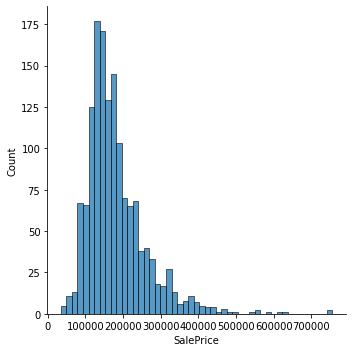

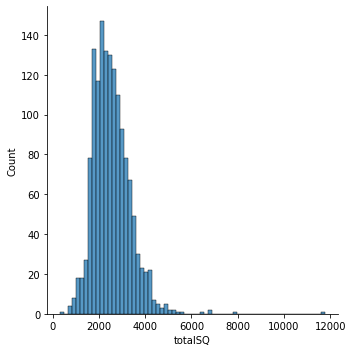

In [8]:
import seaborn as sns
sns.displot(df, x='SalePrice')
sns.displot(df, x='totalSQ')

In [9]:
from scipy import stats

outliers=[]
def detect_outlier(data_1):
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers
priceOutlier=list(detect_outlier(df['SalePrice']))
print(priceOutlier)
sqOutlier=list(detect_outlier(df['totalSQ']))
print(sqOutlier)

[438780, 501837, 475000, 437154, 426000, 555000, 440000, 430000, 446261, 451950, 423000, 755000, 538000, 485000, 582933, 611657, 556581, 424870, 625000, 745000, 465000, 466500]
[438780, 501837, 475000, 437154, 426000, 555000, 440000, 430000, 446261, 451950, 423000, 755000, 538000, 485000, 582933, 611657, 556581, 424870, 625000, 745000, 465000, 466500, 5496, 6428, 7814, 6760, 5066, 5048, 5557, 6872, 11752, 5271, 5266]


In [10]:
#Remove Outliers:
df=df.loc[df['SalePrice']<500_000]
df=df.loc[df['totalSQ']<5000]
print(df.shape) 

(1444, 25)


# Correlations

<AxesSubplot:>

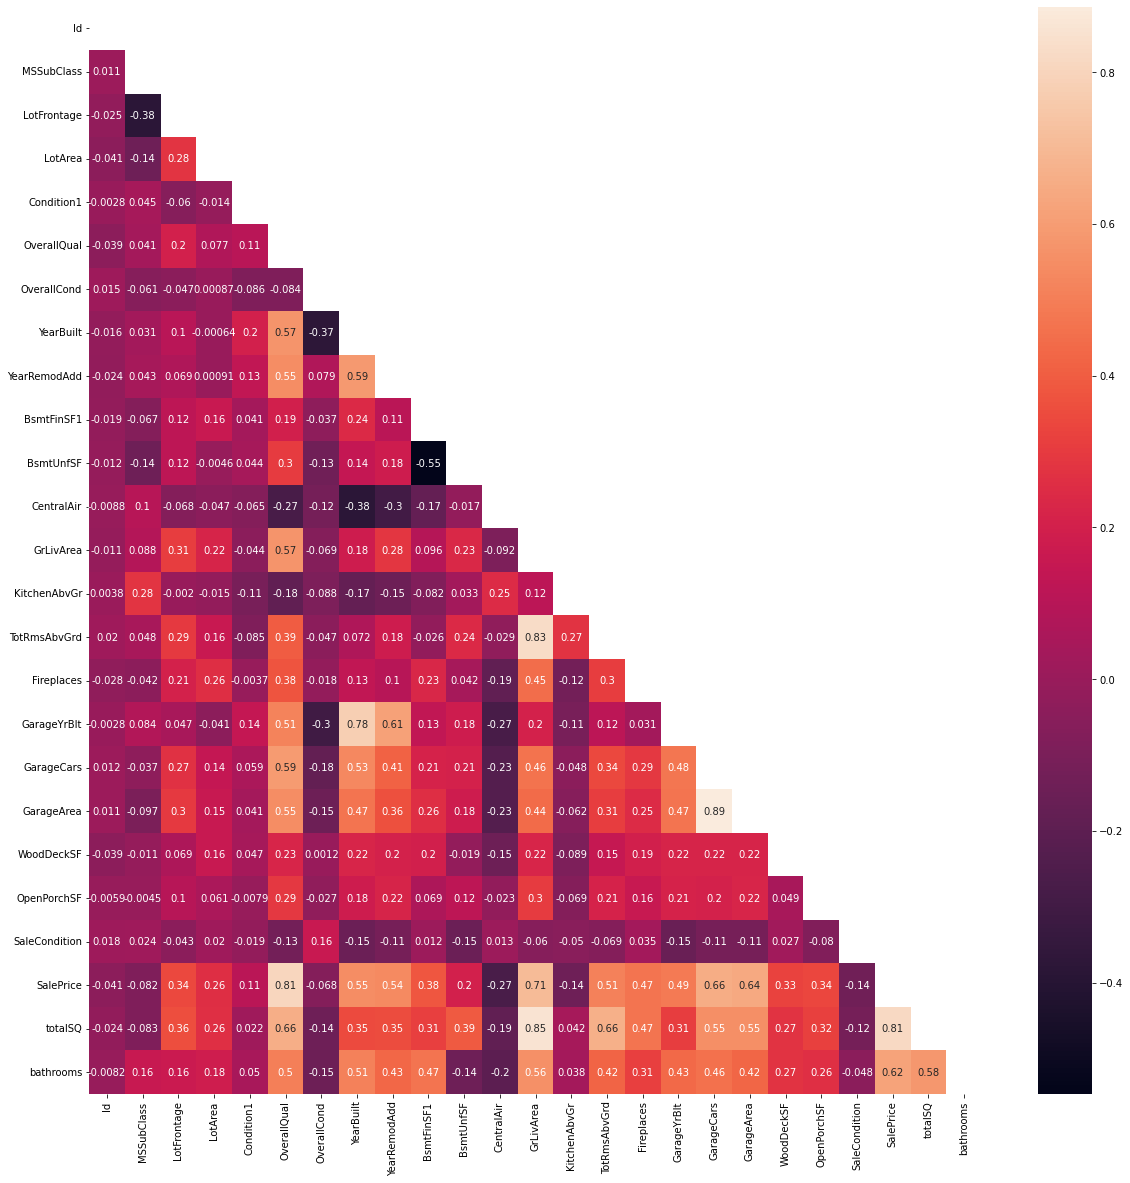

In [11]:
import seaborn as sns
corr= df.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(20,20))    
sns.heatmap(corr, annot=True, mask=matrix)

In [12]:
#Too similiar variables:
df=df.drop(['GarageYrBlt', 'GarageCars'], axis=1) 
#GarageCars and garageArea too smiliar
#GarageYrBlt and houseYear too similiar

# Split Data

In [13]:
from sklearn.model_selection import train_test_split, cross_validate

X=df.drop("SalePrice", axis='columns')
y=df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.30, random_state=42)

# xgBoost

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Max Depth 
Increasing the value makes the model more complex which could overfit. Four for max depth shows the least amount of error and highest accuracy. Range is typical between 2 and 10.

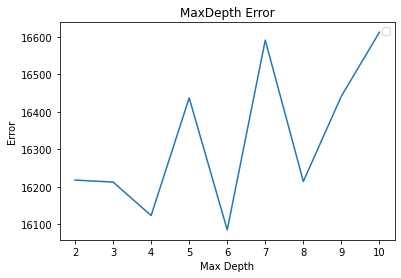

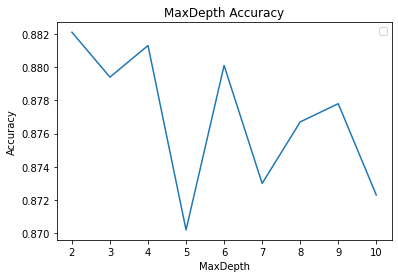

In [15]:
maxDepth=[2, 3, 4, 5, 6, 7, 8, 9, 10]
listMSE=[]
listR2=[]

for d in maxDepth:
    regressor = xgb.XGBRegressor(
        max_depth=d
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
plt.plot(maxDepth, listMSE)
plt.title('MaxDepth Error')
plt.ylabel('Error')
plt.xlabel('Max Depth')
plt.legend()
plt.show()

plt.plot(maxDepth, listR2)
plt.title('MaxDepth Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('MaxDepth')
plt.legend()
plt.show()

### n_estimators


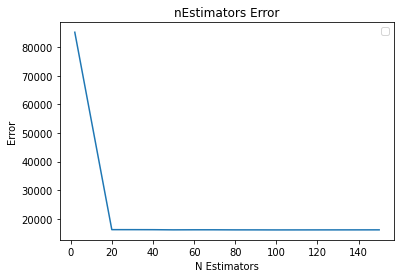

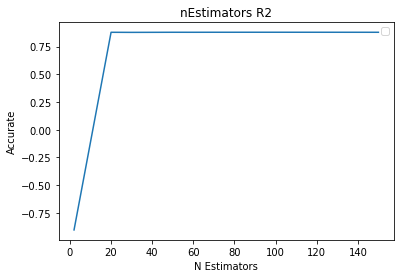

In [16]:
def xgEst():
    numbers=[2, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150]
    listMSE=[]
    listR2=[]

    for n in numbers:
        regressor = xgb.XGBRegressor(
            n_estimators=n,
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)
    plt.plot(numbers, listMSE)
    plt.title('nEstimators Error')
    plt.ylabel('Error')
    plt.xlabel('N Estimators')
    plt.legend()
    plt.show()

    plt.plot(numbers, listR2)
    plt.title('nEstimators R2')
    plt.ylabel('Accurate')
    plt.xlabel('N Estimators')
    plt.legend()
    plt.show()
xgEst()

### Min_child_weight
Increasing value will make model more conservative. Typically, a number between 0 and 10 is used.


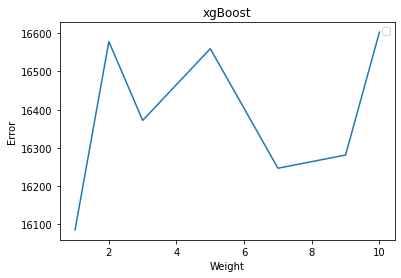

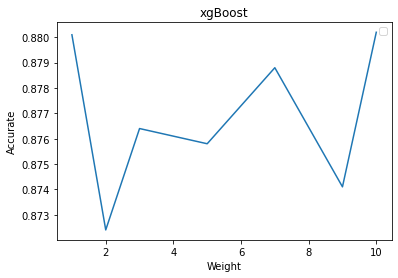

In [17]:
weight=[1, 2, 3, 5, 7, 9, 10]
listMSE=[]
listR2=[]

for w in weight:
    regressor = xgb.XGBRegressor(
        min_child_weight=w
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
plt.plot(weight, listMSE)
plt.title('xgBoost')
plt.ylabel('Error')
plt.xlabel('Weight')
plt.legend()
plt.show()

plt.plot(weight, listR2)
plt.title('xgBoost')
plt.ylabel('Accurate')
plt.xlabel('Weight')
plt.legend()
plt.show()

### Gamma
Increasing gamma makes model more conservative. In this case, increasing Gamma makes almost no difference. It takes gamma to be 1000 to notice a slight decrease in error. Therefore, I do not use gamma in this particular case.

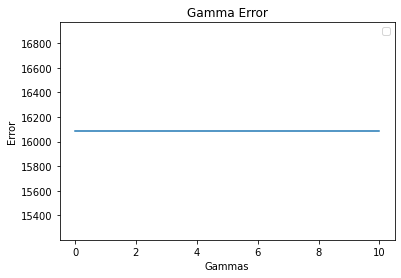

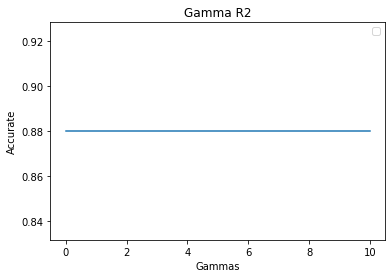

In [18]:
gammas=[0, 0.25, 0.5, 1.0, 3, 5, 10]
listMSE=[]
listR2=[]

for g in gammas:
    regressor = xgb.XGBRegressor(
        min_split_loss=g
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(gammas, listMSE)
plt.title('Gamma Error')
plt.ylabel('Error')
plt.xlabel('Gammas')
plt.legend()
plt.show()

plt.plot(gammas, listR2)
plt.title('Gamma R2')
plt.ylabel('Accurate')
plt.xlabel('Gammas')
plt.legend()
plt.show()

### Learning_rate
A higher learning rate makes the model more conservative. Range is between 0 and 1. Typically, a number between 0 and .3 is used.

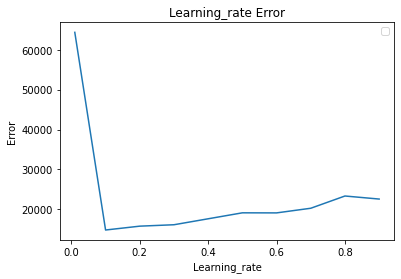

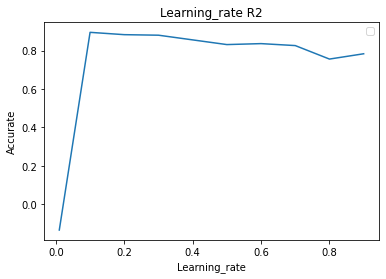

In [19]:
learning_rate = [0.01, 0.1, 0.2, 0.3, .5, .6, .7, .8, .9]
listMSE=[]
listR2=[]

for l in learning_rate:
    regressor = xgb.XGBRegressor(
        learning_rate=l
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(learning_rate, listMSE)
plt.title('Learning_rate Error')
plt.ylabel('Error')
plt.xlabel('Learning_rate')
plt.legend()
plt.show()

plt.plot(learning_rate, listR2)
plt.title('Learning_rate R2')
plt.ylabel('Accurate')
plt.xlabel('Learning_rate')
plt.legend()
plt.show()

### Reg_Lambda
Reg_lambda uses L2 regularization. Typical range is generally 0 to 10.

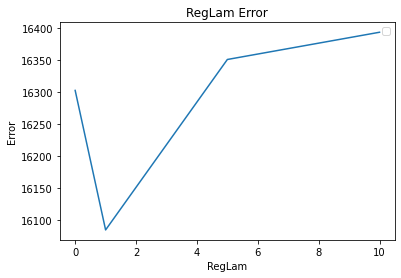

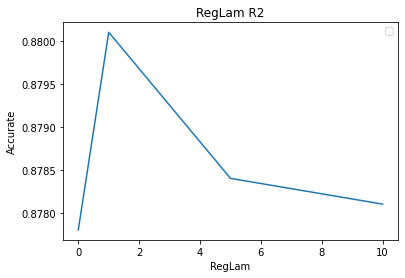

In [20]:
regLam = [0, 1.0, 5.0, 10.0] #0 is default
listMSE=[]
listR2=[]

for r in regLam:
    regressor = xgb.XGBRegressor(
        reg_lambda=r,
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(regLam, listMSE)
plt.title('RegLam Error')
plt.ylabel('Error')
plt.xlabel('RegLam')
plt.legend()
plt.show()

plt.plot(regLam, listR2)
plt.title('RegLam R2')
plt.ylabel('Accurate')
plt.xlabel('RegLam')
plt.legend()
plt.show()

### Reg_Alpha
Reg_alpha uses L1 regularization. Increasing the value makes the model more conservative. Reg_alpha can have a bigger range up to 80.

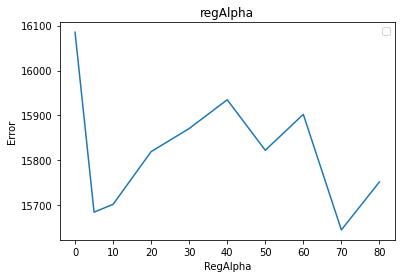

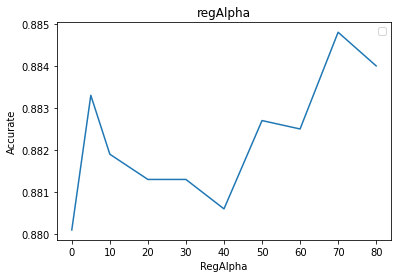

In [21]:
def regAlpha():
    numbers = [0, 5.0, 10.0, 20, 30, 40, 50, 60, 70, 80]  #0 is default
    listMSE=[]
    listR2=[]

    for n in numbers:
        regressor = xgb.XGBRegressor(
            reg_alpha=n,
        )
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        xgMSE=mean_absolute_error(y_test, y_pred)
        xgR2 = r2_score(y_test, y_pred).round(4)
        listMSE.append(xgMSE)
        listR2.append(xgR2)

    plt.plot(numbers, listMSE)
    plt.title('regAlpha')
    plt.ylabel('Error')
    plt.xlabel('RegAlpha')
    plt.legend()
    plt.show()

    plt.plot(numbers, listR2)
    plt.title('regAlpha')
    plt.ylabel('Accurate')
    plt.xlabel('RegAlpha')
    plt.legend()
    plt.show()
regAlpha()

### Colsample_bytree

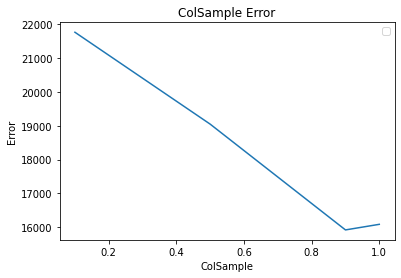

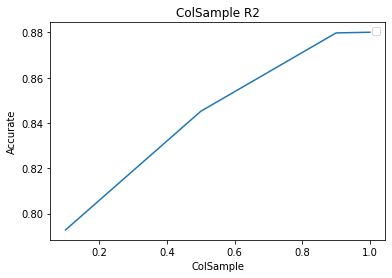

In [22]:
colSample = [0.1, 0.5, 0.9, 1]
listMSE=[]
listR2=[]

for c in colSample:
    regressor = xgb.XGBRegressor(
        colsample_bytree=c
    )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    xgMSE=mean_absolute_error(y_test, y_pred)
    xgR2 = r2_score(y_test, y_pred).round(4)
    listMSE.append(xgMSE)
    listR2.append(xgR2)
    
plt.plot(colSample, listMSE)
plt.title('ColSample Error')
plt.ylabel('Error')
plt.xlabel('ColSample')
plt.legend()
plt.show()

plt.plot(colSample, listR2)
plt.title('ColSample R2')
plt.ylabel('Accurate')
plt.xlabel('ColSample')
plt.legend()
plt.show()

# Grid Search xg Boost

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import f1_score, max_error
from xgboost import cv
from scipy import stats
import time

def gridSearch():
    start=time.time()
    print("Start")

    params = {
        'learning_rate':[.1, .3],
        'n_estimators':[100],
        'max_depth':[2, 3, 4],
        'min_child_weight':[5, 10],
        'reg_lambda':[0, 1, 2],
        'reg_alpha':[0, 20, 40],
        'colsample_bytree':[.9, 1],
    }

    boost_gs=xgb.XGBRegressor()
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    boost_gs=GridSearchCV(boost_gs, param_grid=params, scoring='neg_mean_squared_error', cv =5)
    boost_gs.fit(X_train, y_train)

    print(boost_gs.best_params_)
    print("Done. ", time.time()-start, " seconds")
#gridSearch()

# Final Predictions
Here are some of the best models found by using GridSearch:
* Using cv=10 {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5}
* {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 5}
* {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
* Using MSE with cv=10 {'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'reg_lambda': 0.5}
* Top 47% {'eta': 0.1, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 50, 'reg_lambda': 0.01}
* Using Kfold=5 {'colsample_bytree': 0.5, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50, 'reg_lambda': 0.5}

In [24]:
xgbFinal = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=3,
        reg_lambda=0,
        reg_alpha=20,
        min_child_weight=10,
        learning_rate=.1,
        colsample_bytree=1,
    )
xgbFinal.fit(X_train, y_train)
y_pred = xgbFinal.predict(X_test)

xgMSE=mean_absolute_error(y_test, y_pred)
xgR2 = r2_score(y_test, y_pred).round(4)
listMSE.append(xgMSE)
listR2.append(xgR2)

#xgbFinal.fit(X_train, y_train)
xgbFinal.fit(X_train, y_train, early_stopping_rounds=5, eval_metric="rmse", eval_set=[(X_test, y_test)], verbose=False)
y_pred = xgbFinal.predict(X_test)

xgMSE=mean_absolute_error(y_test, y_pred)
xgR2 = r2_score(y_test, y_pred).round(4)

xgScore = xgbFinal.score(X_test, y_test).round(4)  
xgCV = cross_validate(xgbFinal, X, y, cv = 5, scoring='r2')
xgCV=xgCV['test_score'].mean().round(4)
print("r2 ", xgScore, xgCV, "|| cross validate: ", (xgScore-xgCV).round(4))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


r2  0.8983 0.899 || cross validate:  -0.0007


### Graph

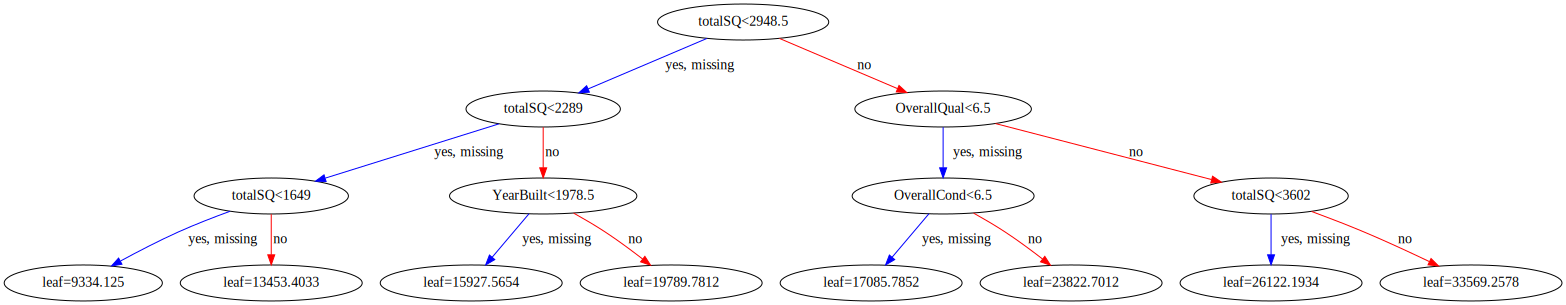

In [25]:
import graphviz
xgb.to_graphviz(xgbFinal)

# Feature Importance

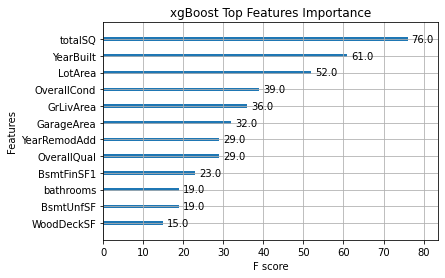

<Figure size 1440x1440 with 0 Axes>

In [26]:
xgb.plot_importance(xgbFinal, max_num_features=12, title='xgBoost Top Features Importance')
plt.figure(figsize = (20, 20))
plt.show()

In [27]:
importance=xgbFinal.feature_importances_
name=xgbFinal.feature_names_in_
print("Feature Importance:")
for num in range(len(name)):
    print(importance[num], " ", name[num])

Feature Importance:
0.00238204   Id
0.006053106   MSSubClass
0.0029320347   LotFrontage
0.0119843595   LotArea
0.0020326045   Condition1
0.44453004   OverallQual
0.010527673   OverallCond
0.015233182   YearBuilt
0.032774005   YearRemodAdd
0.030714484   BsmtFinSF1
0.017871896   BsmtUnfSF
0.019566273   CentralAir
0.011189562   GrLivArea
0.050495777   KitchenAbvGr
0.0023314548   TotRmsAbvGrd
0.037326757   Fireplaces
0.017165346   GarageArea
0.0055889045   WoodDeckSF
0.005921728   OpenPorchSF
0.0041536167   SaleCondition
0.20621279   totalSQ
0.06301237   bathrooms


In [28]:
def randSearch():
    clf_xgb = xgb.XGBRegressor()
    param_dist = {'n_estimators': stats.randint(50, 130),
                  'learning_rate': stats.uniform(0.01, 0.07),
                  'subsample': stats.uniform(0.3, 0.7),
                  'max_depth': [3, 4, 5, 6],
                  'colsample_bytree': stats.uniform(0.5, 0.45),
                  'min_child_weight': [1, 10]
                 }
    clf = RandomizedSearchCV(
        clf_xgb, param_distributions = param_dist, n_iter = 10, 
     scoring = 'r2', error_score = 0, verbose = 3, n_jobs = -1)

    numFolds = 5
    folds = KFold(n_splits = numFolds, shuffle = True)

    estimators = []
    results = np.zeros(len(X))
    score = 0.0
    for train_index, test_index in folds.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
        clf.fit(X_train, y_train)

        estimators.append(clf.best_estimator_)
        results[test_index] = clf.predict(X_test)
        score += r2_score(y_test, results[test_index])
    score /= numFolds

# Test Dataset
Make final predictions on unknown house price value using features from Train data

In [29]:
test='/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
testDF=pd.read_csv(test)
print(testDF.shape)

#Missing Values
testDF=testDF.drop_duplicates()
testDF=testDF.fillna(testDF.mean())

# Feature Engineer
testDF['totalSQ']=testDF['1stFlrSF']+testDF['2ndFlrSF']+testDF['TotalBsmtSF']
testDF['bathrooms']=(testDF['FullBath']*2+testDF['BsmtFullBath']*2+testDF['FullBath']+testDF['HalfBath']+testDF['BsmtHalfBath'])/2
testDF['CentralAir'] = testDF['CentralAir'].replace({'Y':0, 'N':1})
testDF['SaleCondition']=testDF['SaleCondition'].apply(lambda x:1 if x == 'Normal' else 0)
testDF['Condition1']=testDF['Condition1'].apply(lambda x: 1 if x=='Norm' else 0)
#testDF['hasPool']=testDF['PoolArea'].apply(lambda x: 1 if x>0 else 0)

testDF = testDF.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
testDF.head()

(1459, 80)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


,Id,MSSubClass,LotFrontage,LotArea,Condition1,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition,totalSQ,bathrooms
0,1461,20,80.0,11622,0,5,6,1961,1961,0.0,...,0,0,120,0,0,6,2010,1,1778.0,1.5
1,1462,20,81.0,14267,1,6,6,1958,1958,108.0,...,0,0,0,0,12500,6,2010,1,2658.0,2.0
2,1463,60,74.0,13830,1,5,5,1997,1998,0.0,...,0,0,0,0,0,3,2010,1,2557.0,3.5
3,1464,60,78.0,9978,1,6,6,1998,1998,20.0,...,0,0,0,0,0,6,2010,1,2530.0,3.5
4,1465,120,43.0,5005,1,8,5,1992,1992,0.0,...,0,0,144,0,0,1,2010,1,2560.0,3.0


In [30]:
testIDs=testDF['Id']
cols=X_test.columns
testDF=testDF[cols]

In [31]:
#Final Prediction
finalPred=xgbFinal.predict(testDF).round(2)
tupDF=list(zip(testIDs,finalPred))

In [32]:
output=pd.DataFrame(tupDF, columns=['Id','SalePrice']).sort_values(by='Id').reset_index(drop=True)
output.head()

,Id,SalePrice
0,1461,129721.148438
1,1462,166865.125000
2,1463,190859.234375
3,1464,206356.437500
4,1465,188658.640625


#### Final Prediction

In [33]:
print(output.shape)
output.to_csv('submission.csv', index=False)
print("Output Created")

(1459, 2)
Output Created
